# CHF Prediction with XGBoost using Short-Term HRV Signals

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import xgboost

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, \
                            recall_score, f1_score, fbeta_score, classification_report, \
                            roc_auc_score, \
                            ConfusionMatrixDisplay, RocCurveDisplay

import datetime
import os
import pprint

In [24]:
def classification_report_heatmap(cr, label_names, model_name):
    corr_matrix = []

    for label in label_names:
        if cr[label]:
            row = [cr[label]['precision'], cr[label]['recall'], cr[label]['f1-score']]
            corr_matrix.append(row)

    sns.heatmap(
        pd.DataFrame(np.array(corr_matrix), index=label_names, columns=['precision', 'recall', 'f1-score']),
        annot=True,
        cmap='Blues',
        vmin=0,
        vmax=1
    )

    plt.title("Classification Report Heatmap\nModel: {0}".format(model_name))
    plt.tight_layout()
    plt.show()

## Load Dataset

In [25]:
import pathlib

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
pathlib.Path(par_dir).parent.absolute()

WindowsPath('c:/Users/BIOINFO 9/Documents/Rino/HRV')

In [26]:
PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
# PROJECT_DIR = pathlib.Path(par_dir).parent.absolute()
# PROJECT_DIR = "/content/drive/MyDrive/Projects/HRV"
DATA_DIR = os.path.join(PROJECT_DIR, "dataset/short-term")

In [27]:
MINS_DIR = "5-min-2-hours-0.5-overlap-normal-beat-with-ectopic-info"
df_nsrdb = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_nsrdb.xlsx"))
df_chfdb = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_chfdb.xlsx"))
df_nsr2db = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_nsr2db.xlsx"))
df_chf2db = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_chf2db.xlsx"))
df = pd.concat(
    [
        df_nsrdb,
        df_chfdb,
        df_nsr2db,
        df_chf2db
    ],
    axis=0
).reset_index(drop=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5472 entries, 0 to 5471
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5472 non-null   object 
 1   start_secs              5472 non-null   int64  
 2   end_secs                5472 non-null   int64  
 3   db_source               5472 non-null   object 
 4   age                     5472 non-null   object 
 5   gender                  5472 non-null   object 
 6   fs                      5472 non-null   int64  
 7   signal_length           1584 non-null   float64
 8   recording_time_hours    1584 non-null   float64
 9   recording_time_seconds  1584 non-null   float64
 10  normal_beats            5472 non-null   int64  
 11  abnormal_beats          5472 non-null   int64  
 12  normal_beats_ratio      5472 non-null   float64
 13  rri_length              5472 non-null   int64  
 14  nni_length              5472 non-null   

## Data Cleaning & Filtering

In [29]:
df_loaded = df.copy()

In [30]:
map_gender = {"m": 1, "f": 0}

# df = df.dropna()
df = df_loaded.copy()
df = df[(df.age != "?") & (df.gender != "?")]
df = df.replace(["?"], np.nan)
df['age'] = np.array(df['age'], dtype=np.float16)
df['gender'] = df['gender'].map(lambda x: map_gender[x.lower()])
df["record_ids"] = df["id"].map(lambda x: "-".join(x.split("-")[:2]))
df = df[["id", "record_ids"] + df.drop(columns=["id", "record_ids"]).columns.to_list()]
df = df.drop(columns=['tinn'])
df = df.replace([np.inf, -np.inf], np.nan)
# df = df[df['age'] >= 10] # useless since no data with age > 10 in CHFDB, CHF2DB, NSRDB, NSR2DB
df = df[df["normal_beats_ratio"] >= 0.9]

if 'db_source' in df.columns:
    db_source = df['db_source']
    df = df.drop(columns=['db_source'])
drop_columns = ["signal_length", "recording_time_hours", "recording_time_seconds"]
df = df.drop(columns=drop_columns)

df = df.dropna()
df["ratio_sd1_sd2"] = 1 / df["ratio_sd2_sd1"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4390 entries, 0 to 4614
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  4390 non-null   object 
 1   record_ids          4390 non-null   object 
 2   start_secs          4390 non-null   int64  
 3   end_secs            4390 non-null   int64  
 4   age                 4390 non-null   float16
 5   gender              4390 non-null   int64  
 6   fs                  4390 non-null   int64  
 7   normal_beats        4390 non-null   int64  
 8   abnormal_beats      4390 non-null   int64  
 9   normal_beats_ratio  4390 non-null   float64
 10  rri_length          4390 non-null   int64  
 11  nni_length          4390 non-null   int64  
 12  mean_nni            4390 non-null   float64
 13  sdnn                4390 non-null   float64
 14  sdsd                4390 non-null   float64
 15  nni_50              4390 non-null   int64  
 16  pnni_5

In [31]:
db_source.value_counts()

nsr2db    2517
nsrdb      780
chfdb      665
chf2db     428
Name: db_source, dtype: int64

## Train-Test Split

In [32]:
train_record_ids = pd.read_csv(os.path.join(PROJECT_DIR, "dataset", "train_record_ids_7-3_post-filter.csv"))
test_record_ids = pd.read_csv(os.path.join(PROJECT_DIR, "dataset", "test_record_ids_7-3_post-filter.csv"))

df_train = df[
    df["record_ids"].isin(train_record_ids["id"].values)
]

df_test = df[
    df["record_ids"].isin(test_record_ids["id"].values)
]

print(df_train.shape)
print(df_test.shape)

df_train.sample(3)

(3113, 46)
(1277, 46)


,id,record_ids,start_secs,end_secs,age,gender,fs,normal_beats,abnormal_beats,normal_beats_ratio,...,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk,ratio_sd1_sd2
2340,nsr2db-nsr016-7050-7350,nsr2db-nsr016,7050,7350,73.0,0,128,352,9,0.975069,...,43.895351,85.036699,1.937260,1.937260,4.776145,658.952706,0.786116,Sinus,0,0.516193
4298,chf2db-chf204-2550-2850,chf2db-chf204,2550,2850,62.0,1,128,406,11,0.973621,...,27.724422,50.840649,1.833786,1.833786,4.353194,372.923421,0.716031,NYHA class: III,1,0.545320
2788,nsr2db-nsr026-3450-3750,nsr2db-nsr026,3450,3750,72.0,1,128,484,6,0.987755,...,30.605346,64.902115,2.120614,2.120614,4.502176,550.529253,0.640736,Sinus,0,0.471562


In [33]:
df_inspect = df_test.copy()

In [34]:
data_info = ['age', 'gender', 'db_source']
time_domain_indices = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr']
freq_domain_indices = ['lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf']
geometrical_indices = ['triangular_index']
poincare_plot_indices = ['sd1', 'sd2', 'ratio_sd1_sd2']
csi_csv_indices = ['csi', 'cvi', 'Modified_csi']
sampen = ['sampen']
disease_info = ['cardiac_info', 'risk']

## Feature Selection

In [35]:
columns_needed = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices + \
                 ['risk']
                #  sampen + \
                #  geometrical_indices + \

df_train = df_train[columns_needed]
df_test = df_test[columns_needed]

X_train = df_train.drop(columns=['risk'])
y_train = df_train['risk']
X_test = df_test.drop(columns=['risk'])
y_test = df_test['risk']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3113, 31) (3113,)
(1277, 31) (1277,)


In [36]:
print(y_train.value_counts())
print(y_test.value_counts())

0    2326
1     787
Name: risk, dtype: int64
0    971
1    306
Name: risk, dtype: int64


In [37]:
pd.set_option('display.max_columns', None)
df_train.sample(3)

,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi,risk
2231,65.0,0,672.471910,47.209449,13.720082,2,0.450450,53,11.936937,13.720804,671.8750,257.8125,0.020404,0.070203,89.649519,108.169014,73.846154,6.101992,209.610579,24.050847,8.715310,89.706967,10.293033,609.086537,375.425111,9.712507,66.054003,0.147039,6.800922,4.011350,1796.912544,0
1289,63.0,0,581.147287,6.410066,8.349627,1,0.194175,9,1.747573,8.349641,580.0000,60.0000,0.014368,0.011030,103.256551,107.913669,97.402597,1.134726,3.991735,11.435103,0.349077,25.875265,74.124735,18.115265,2.688426,5.909818,6.874005,0.859734,1.163150,2.812904,31.981993,1
859,50.0,0,538.152442,15.587886,9.268693,0,0.000000,16,2.872531,9.268735,539.0625,109.3750,0.017223,0.028966,111.584595,120.000000,98.461538,3.182618,60.778027,12.525744,4.852249,82.912551,17.087449,122.730499,49.426728,6.559847,21.045969,0.311691,3.208302,3.344183,270.087299,0


In [38]:
pd.reset_option('display.max_columns')

In [39]:
LABEL_NAMES = ["Healthy", "CHF"]

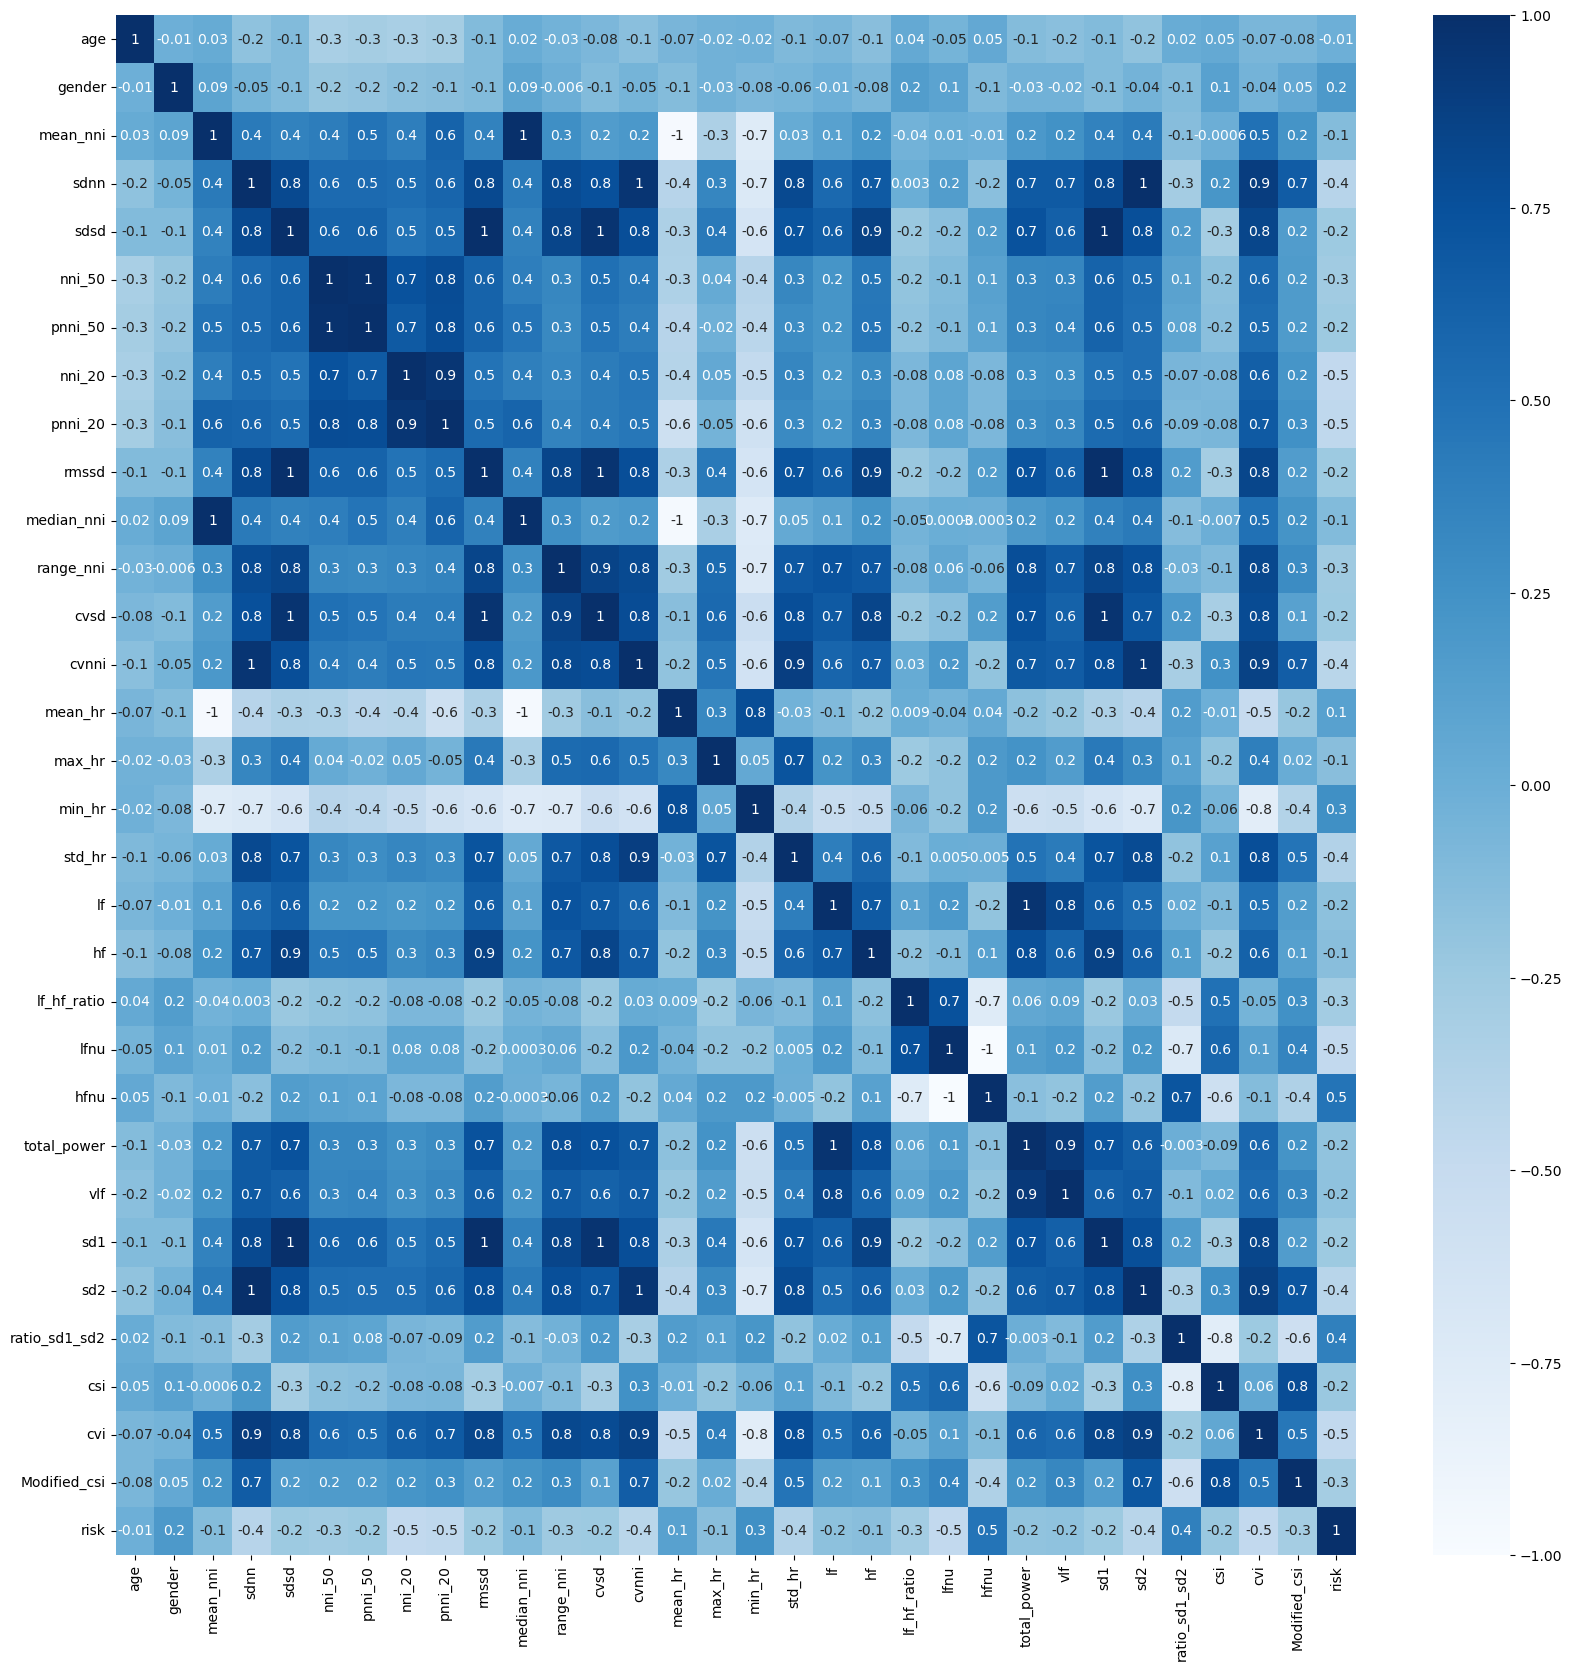

In [40]:
plt.rcParams['figure.figsize'] = (20, 20)
heatmap = sns.heatmap(df_train.corr(), annot=True, cmap="Blues", fmt='.1g')
plt.rcdefaults()
plt.show()

## XGBoost

In [41]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut

from sklearn.metrics import make_scorer

In [42]:
# A parameter grid for XGBoost
params = {
    'learning_rate': [0.2, 0.3, 0.4],
    'n_estimators': [50, 75, 100, 125, 150, 175, 200],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 5, 10],
    'gamma': [1, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

RUN      - 1
SEED     - 870
Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 31)
Fitting time: 0 hours, 9 minutes, 39 seconds, 251698 microseconds


0.9600626468285043

TEST SET RESULTS
TN, FP, FN, TP       : 932 39 12 294
Accuracy             : 0.9600626468285043
Precision            : 0.9622701188905083
Sensitivity          : 0.9607843137254902
Specificity          : 0.9598352214212152
F1-Score             : 0.9606248510278956
AUC Score            : 0.9603097675733527
              precision    recall  f1-score   support

     Healthy       0.99      0.96      0.97       971
         CHF       0.88      0.96      0.92       306

    accuracy                           0.96      1277
   macro avg       0.94      0.96      0.95      1277
weighted avg       0.96      0.96      0.96      1277




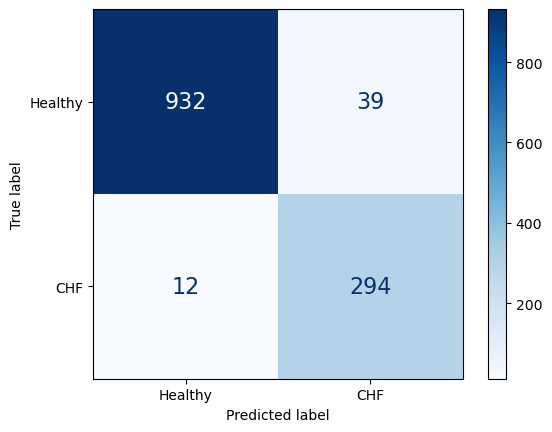

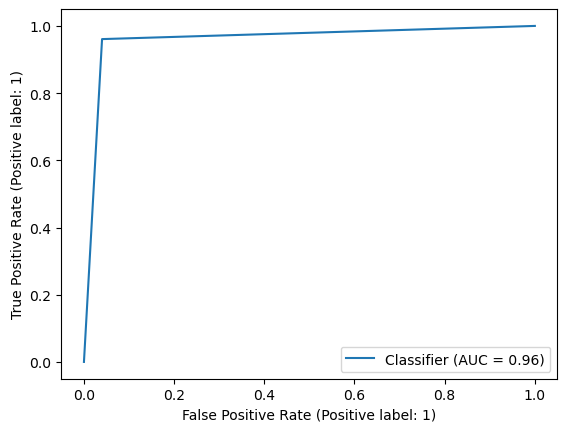

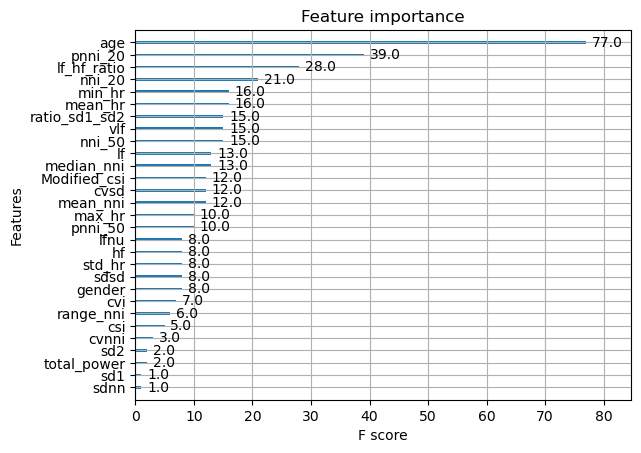

Best Params
{'colsample_bytree': 0.8,
 'gamma': 1,
 'learning_rate': 0.3,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 200,
 'subsample': 0.6}


RUN      - 2
SEED     - 274
Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 31)
Fitting time: 0 hours, 9 minutes, 41 seconds, 41332 microseconds


0.9624119028974158

TEST SET RESULTS
TN, FP, FN, TP       : 937 34 14 292
Accuracy             : 0.9624119028974158
Precision            : 0.9638147710661861
Sensitivity          : 0.954248366013072
Specificity          : 0.964984552008239
F1-Score             : 0.96281108364649
AUC Score            : 0.9596164590106555
              precision    recall  f1-score   support

     Healthy       0.99      0.96      0.98       971
         CHF       0.90      0.95      0.92       306

    accuracy                           0.96      1277
   macro avg       0.94      0.96      0.95      1277
weighted avg       0.96      0.96      0.96      1277




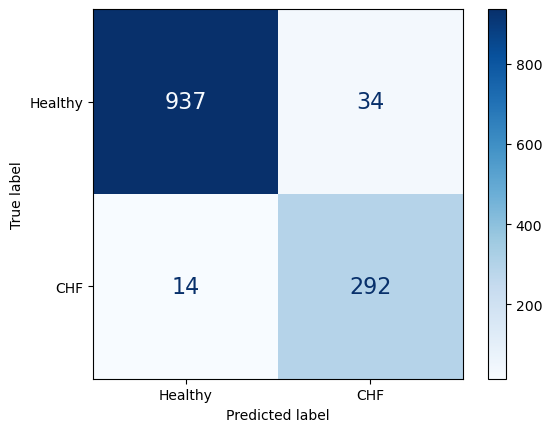

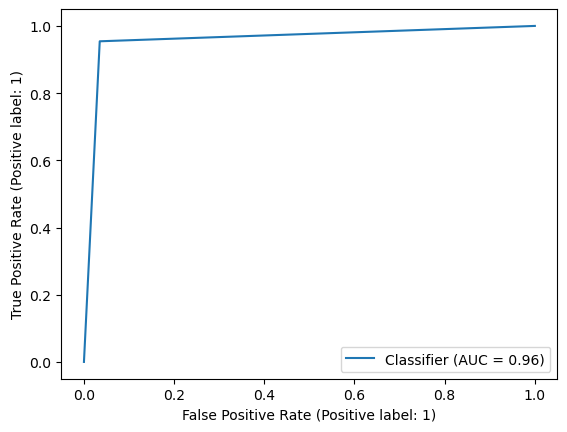

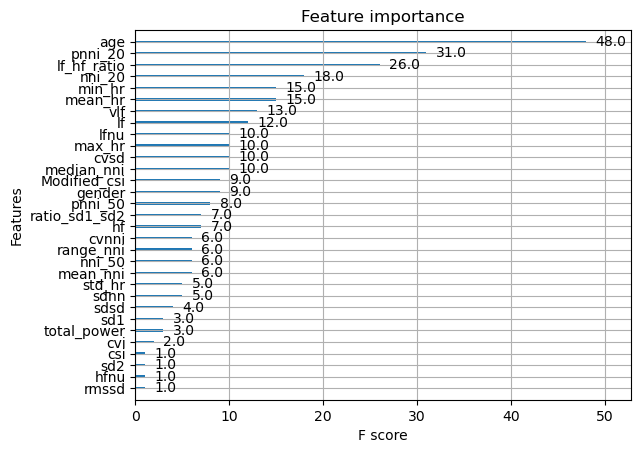

Best Params
{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.4,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 100,
 'subsample': 0.6}


RUN      - 3
SEED     - 662
Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 31)
Fitting time: 0 hours, 9 minutes, 43 seconds, 138223 microseconds


0.961628817541112

TEST SET RESULTS
TN, FP, FN, TP       : 935 36 13 293
Accuracy             : 0.961628817541112
Precision            : 0.9633526362422444
Sensitivity          : 0.9575163398692811
Specificity          : 0.9629248197734295
F1-Score             : 0.9620937815604199
AUC Score            : 0.9602205798213553
              precision    recall  f1-score   support

     Healthy       0.99      0.96      0.97       971
         CHF       0.89      0.96      0.92       306

    accuracy                           0.96      1277
   macro avg       0.94      0.96      0.95      1277
weighted avg       0.96      0.96      0.96      1277




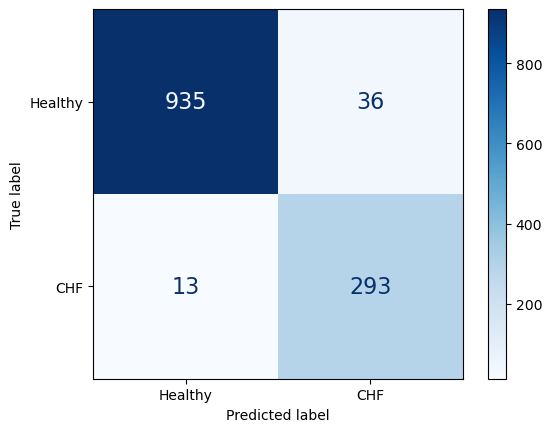

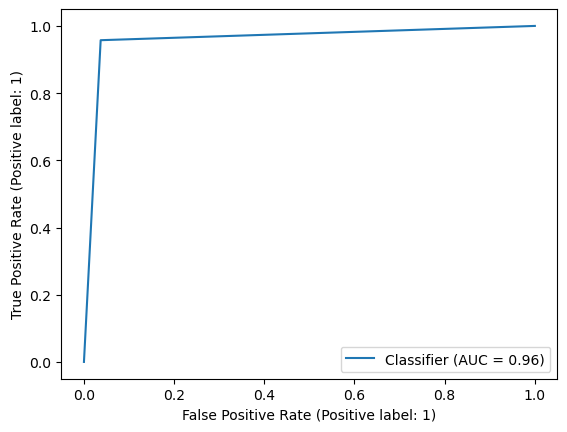

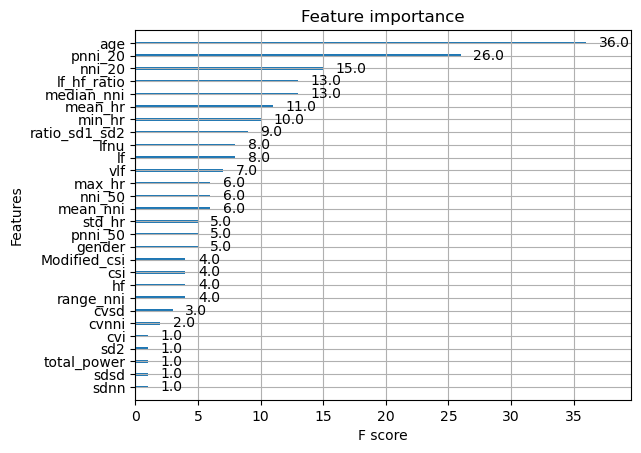

Best Params
{'colsample_bytree': 0.6,
 'gamma': 2,
 'learning_rate': 0.4,
 'max_depth': 6,
 'min_child_weight': 10,
 'n_estimators': 125,
 'subsample': 0.8}


RUN      - 4
SEED     - 433
Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 31)
Fitting time: 0 hours, 9 minutes, 45 seconds, 56972 microseconds


0.966327329678935

TEST SET RESULTS
TN, FP, FN, TP       : 939 32 11 295
Accuracy             : 0.966327329678935
Precision            : 0.9677461926208479
Sensitivity          : 0.9640522875816994
Specificity          : 0.9670442842430484
F1-Score             : 0.966701829526732
AUC Score            : 0.965548285912374
              precision    recall  f1-score   support

     Healthy       0.99      0.97      0.98       971
         CHF       0.90      0.96      0.93       306

    accuracy                           0.97      1277
   macro avg       0.95      0.97      0.95      1277
weighted avg       0.97      0.97      0.97      1277




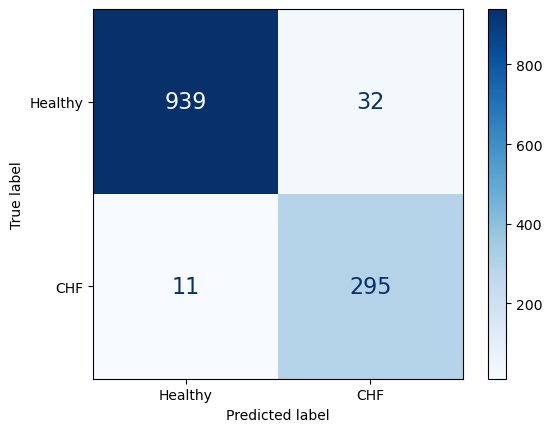

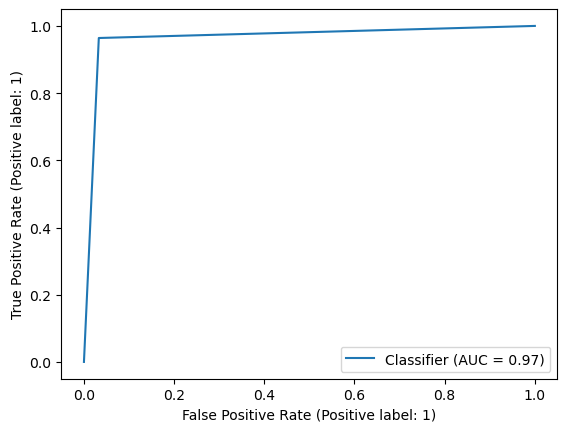

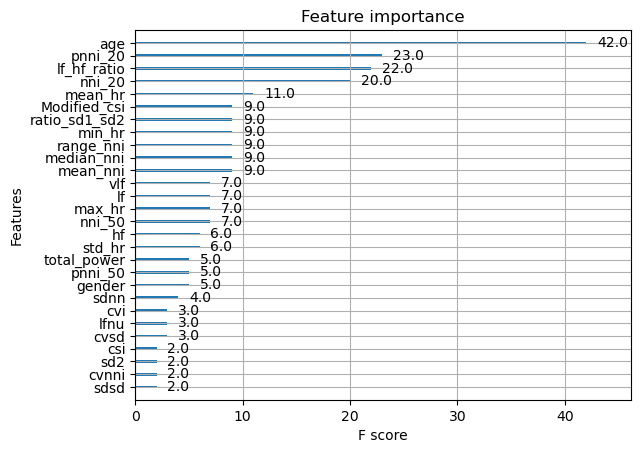

Best Params
{'colsample_bytree': 0.8,
 'gamma': 1,
 'learning_rate': 0.4,
 'max_depth': 3,
 'min_child_weight': 10,
 'n_estimators': 100,
 'subsample': 0.6}


RUN      - 5
SEED     - 996
Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 31)
Fitting time: 0 hours, 9 minutes, 45 seconds, 249595 microseconds


0.9545810493343775

TEST SET RESULTS
TN, FP, FN, TP       : 938 33 25 281
Accuracy             : 0.9545810493343775
Precision            : 0.9550768050206551
Sensitivity          : 0.9183006535947712
Specificity          : 0.9660144181256437
F1-Score             : 0.9547801369721486
AUC Score            : 0.9421575358602075
              precision    recall  f1-score   support

     Healthy       0.97      0.97      0.97       971
         CHF       0.89      0.92      0.91       306

    accuracy                           0.95      1277
   macro avg       0.93      0.94      0.94      1277
weighted avg       0.96      0.95      0.95      1277




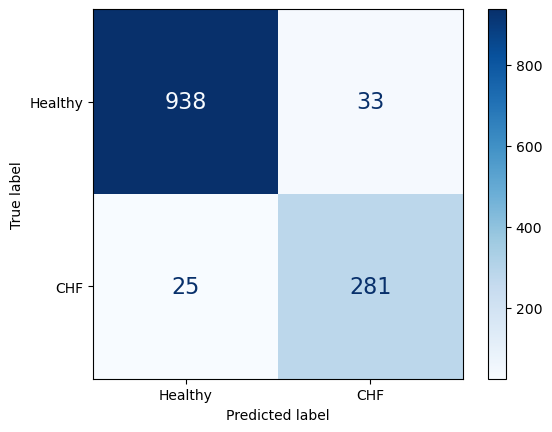

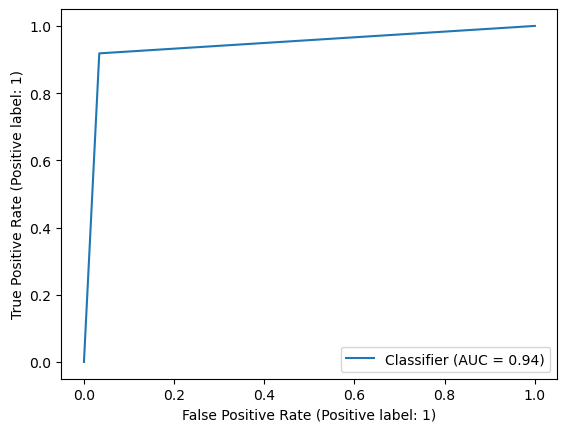

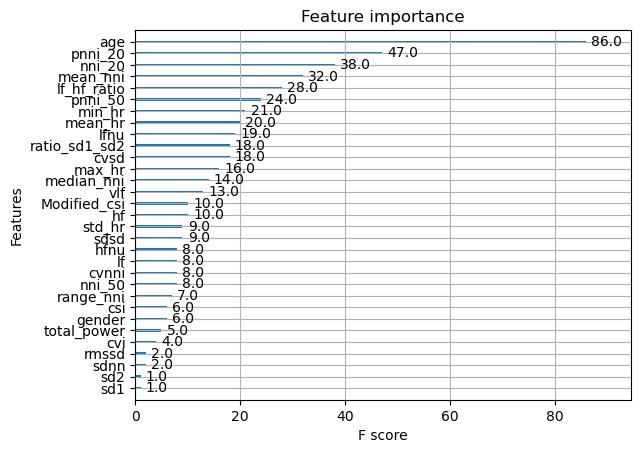

Best Params
{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 125,
 'subsample': 0.8}


RUN      - 6
SEED     - 186
Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 31)
Fitting time: 0 hours, 9 minutes, 41 seconds, 825521 microseconds


0.9600626468285043

TEST SET RESULTS
TN, FP, FN, TP       : 930 41 10 296
Accuracy             : 0.9600626468285043
Precision            : 0.9627578121527589
Sensitivity          : 0.9673202614379085
Specificity          : 0.9577754891864058
F1-Score             : 0.9607014375076879
AUC Score            : 0.9625478753121571
              precision    recall  f1-score   support

     Healthy       0.99      0.96      0.97       971
         CHF       0.88      0.97      0.92       306

    accuracy                           0.96      1277
   macro avg       0.93      0.96      0.95      1277
weighted avg       0.96      0.96      0.96      1277




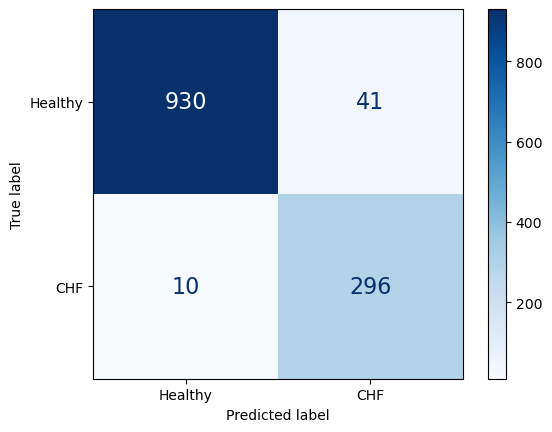

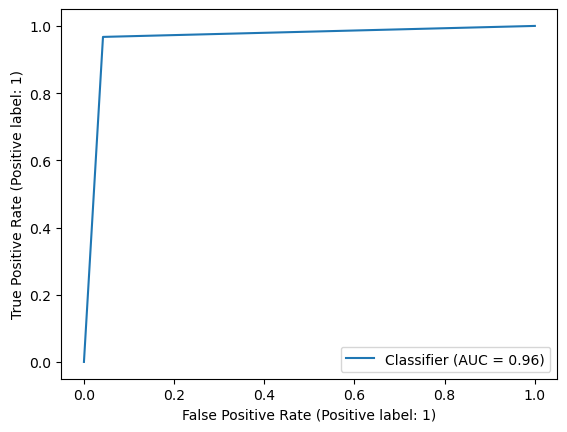

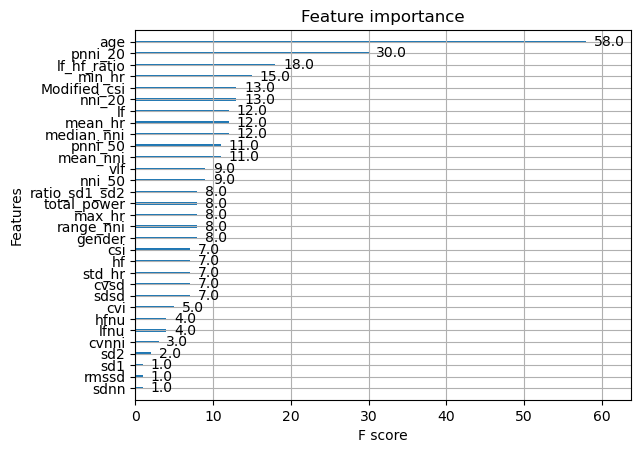

Best Params
{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.4,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 150,
 'subsample': 0.6}


RUN      - 7
SEED     - 257
Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 31)
Fitting time: 0 hours, 9 minutes, 47 seconds, 136378 microseconds


0.9647611589663273

TEST SET RESULTS
TN, FP, FN, TP       : 934 37 8 298
Accuracy             : 0.9647611589663273
Precision            : 0.9670765078884614
Sensitivity          : 0.9738562091503268
Specificity          : 0.9618949536560247
F1-Score             : 0.9652911929680423
AUC Score            : 0.9678755814031759
              precision    recall  f1-score   support

     Healthy       0.99      0.96      0.98       971
         CHF       0.89      0.97      0.93       306

    accuracy                           0.96      1277
   macro avg       0.94      0.97      0.95      1277
weighted avg       0.97      0.96      0.97      1277




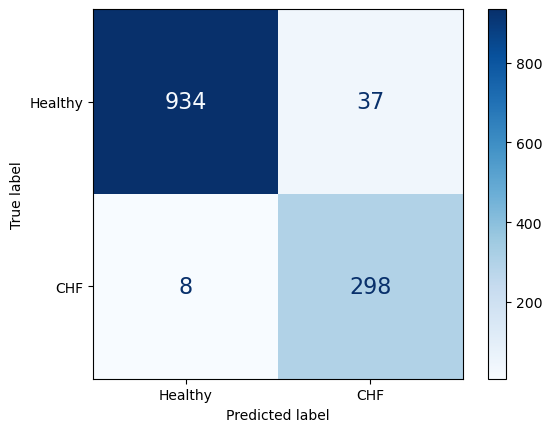

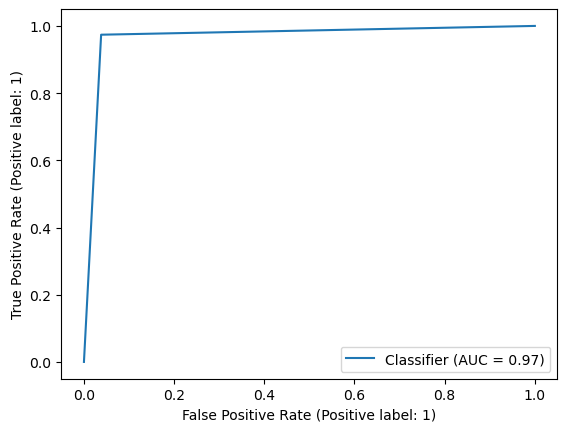

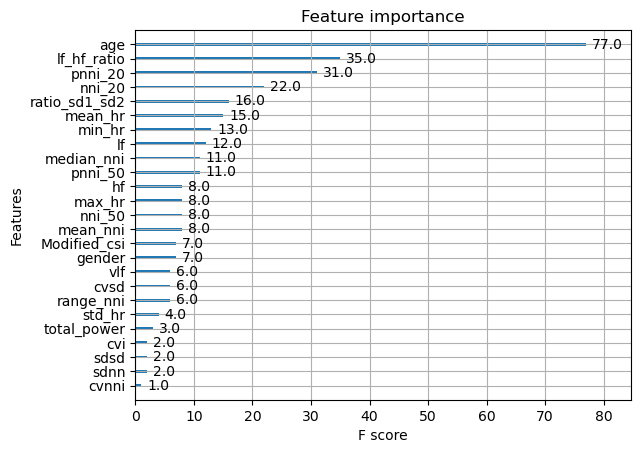

Best Params
{'colsample_bytree': 1.0,
 'gamma': 2,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 200,
 'subsample': 0.6}


RUN      - 8
SEED     - 420
Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 31)
Fitting time: 0 hours, 9 minutes, 47 seconds, 135268 microseconds


0.9584964761158966

TEST SET RESULTS
TN, FP, FN, TP       : 934 37 16 290
Accuracy             : 0.9584964761158966
Precision            : 0.9600802369447646
Sensitivity          : 0.9477124183006536
Specificity          : 0.9618949536560247
F1-Score             : 0.9589580689515533
AUC Score            : 0.9548036859783391
              precision    recall  f1-score   support

     Healthy       0.98      0.96      0.97       971
         CHF       0.89      0.95      0.92       306

    accuracy                           0.96      1277
   macro avg       0.94      0.95      0.94      1277
weighted avg       0.96      0.96      0.96      1277




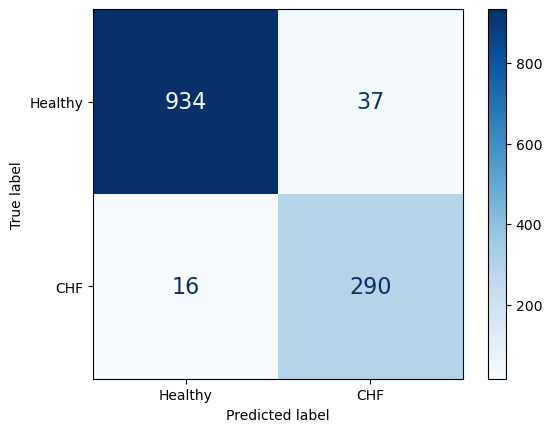

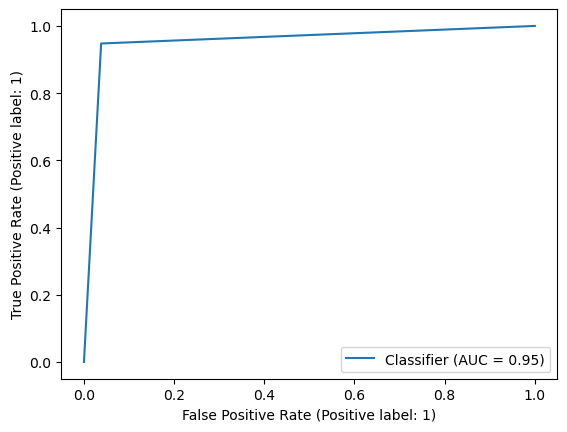

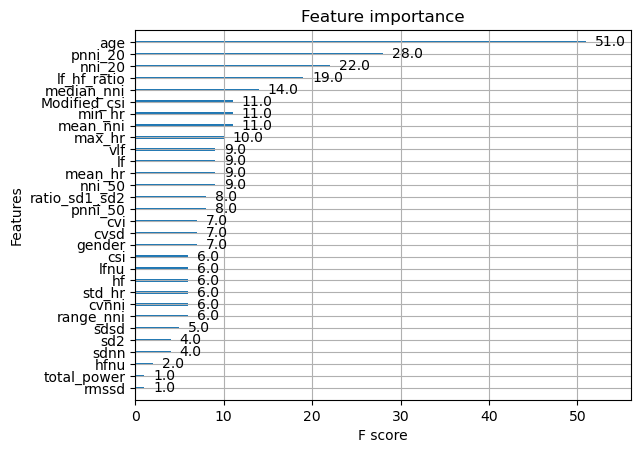

Best Params
{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.4,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 75,
 'subsample': 0.6}


RUN      - 9
SEED     - 696
Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 31)
Fitting time: 0 hours, 9 minutes, 46 seconds, 369381 microseconds


0.9584964761158966

TEST SET RESULTS
TN, FP, FN, TP       : 935 36 17 289
Accuracy             : 0.9584964761158966
Precision            : 0.9598788799297805
Sensitivity          : 0.9444444444444444
Specificity          : 0.9629248197734295
F1-Score             : 0.9589162954619507
AUC Score            : 0.953684632108937
              precision    recall  f1-score   support

     Healthy       0.98      0.96      0.97       971
         CHF       0.89      0.94      0.92       306

    accuracy                           0.96      1277
   macro avg       0.94      0.95      0.94      1277
weighted avg       0.96      0.96      0.96      1277




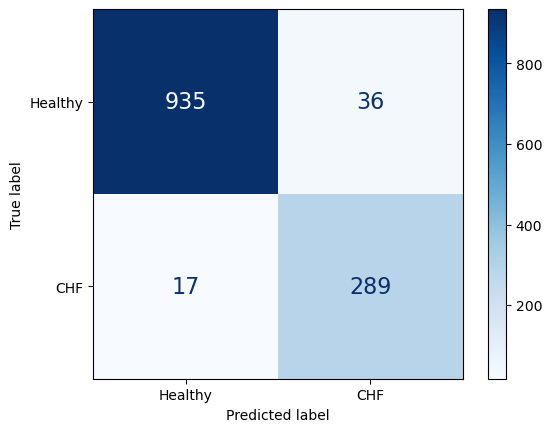

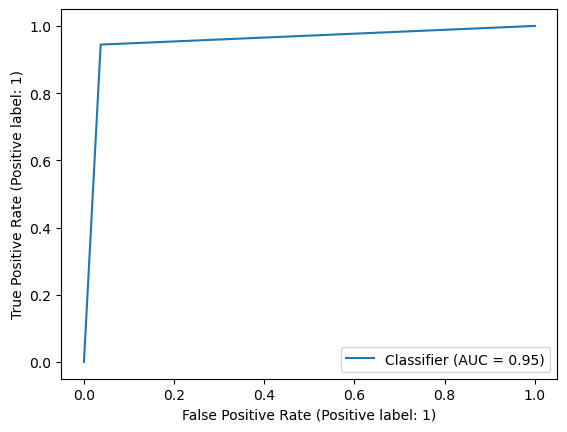

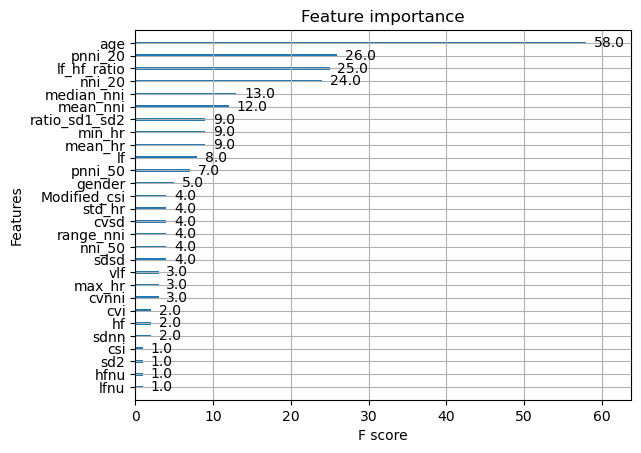

Best Params
{'colsample_bytree': 0.8,
 'gamma': 2,
 'learning_rate': 0.4,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 125,
 'subsample': 0.6}


RUN      - 10
SEED     - 308
Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 31)
Fitting time: 0 hours, 9 minutes, 47 seconds, 277588 microseconds


0.9600626468285043

TEST SET RESULTS
TN, FP, FN, TP       : 930 41 10 296
Accuracy             : 0.9600626468285043
Precision            : 0.9627578121527589
Sensitivity          : 0.9673202614379085
Specificity          : 0.9577754891864058
F1-Score             : 0.9607014375076879
AUC Score            : 0.9625478753121571
              precision    recall  f1-score   support

     Healthy       0.99      0.96      0.97       971
         CHF       0.88      0.97      0.92       306

    accuracy                           0.96      1277
   macro avg       0.93      0.96      0.95      1277
weighted avg       0.96      0.96      0.96      1277




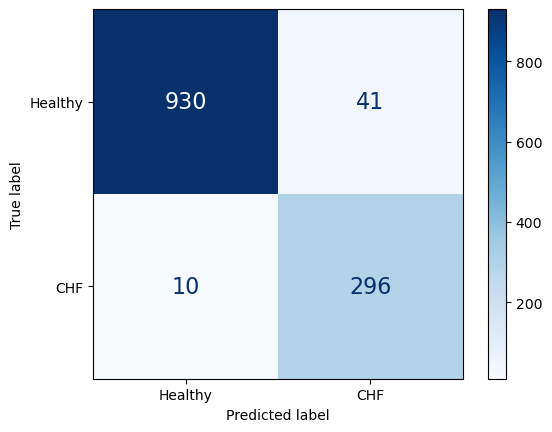

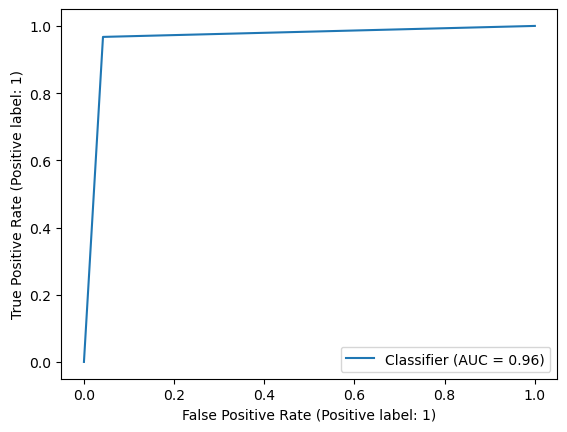

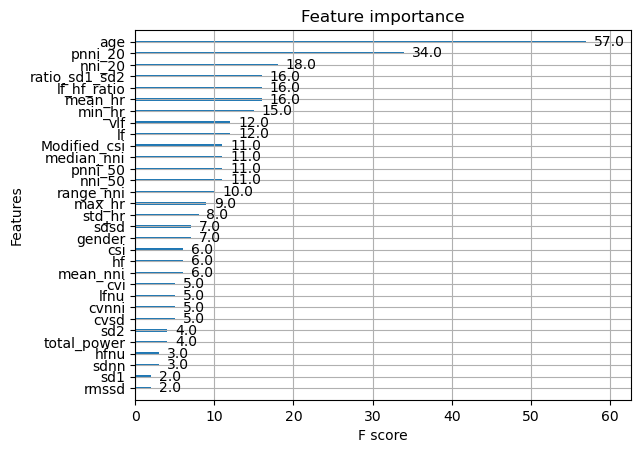

Best Params
{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.4,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 200,
 'subsample': 0.6}




In [43]:
runs = []
for _run in range(0, 10):
    print("RUN      -", _run+1)
    seed = np.random.randint(0, 1000)
    # seed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
    print("SEED     -", seed)
    xgb = XGBClassifier(
        objective='binary:logistic',
        seed=seed
    )

    gs = GridSearchCV(
        xgb,
        param_grid=params,
        n_jobs=30,
        verbose=3,
        return_train_score=True,
        cv=StratifiedKFold(n_splits=10),
        scoring="accuracy"
    )

    start = datetime.datetime.now()
    gs.fit(X_train, y_train)
    fit_time = datetime.datetime.now() - start
    print("Train data shape:", X_train.shape)

    text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
        fit_time.seconds // 3600,
        fit_time.seconds % 3600 // 60,
        fit_time.seconds % 60,
        fit_time.microseconds
    )
    print(text)
    runs.append(gs)

    display(gs.score(X_test, y_test))

    # y_pred_train = gs.best_estimator_.predict(X_train)
    # AVERAGE = 'weighted'
    # tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
    # accuracy_train = accuracy_score(y_train, y_pred_train)
    # precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
    # f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
    # sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
    # specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
    # auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
    # print("TRAIN SET RESULTS")
    # print("TN, FP, FN, TP       :", tn, fp, fn, tp)
    # print("Accuracy (Train)     :", accuracy_train)
    # print("Precision (Train)    :", precision_train)
    # print("Sensitivity (Train)  :", sensitivity_train)
    # print("Specificity (Train)  :", specificity_train)
    # print("F1-Score (Train)     :", f1_train)
    # print("AUC Score (Train)    :", auc_train)
    # print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
    # print()
    # ConfusionMatrixDisplay.from_predictions(
    #     y_train, y_pred_train,
    #     display_labels=LABEL_NAMES,
    #     cmap=plt.cm.Blues,
    #     text_kw={
    #         "fontsize": 16
    #     }
    # )
    # plt.show()
    # print()

    y_pred = gs.best_estimator_.predict(X_test)
    AVERAGE = 'weighted'
    acc = accuracy_score(y_true=y_test, y_pred=y_pred)
    f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    num_positives = len(np.where(y_test == 1)[0])
    num_negatives = len(np.where(y_test == 0)[0])
    precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    _precision = precision_score(y_test, y_pred, average=AVERAGE)
    _sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
    _specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
    assert precision == _precision
    assert specificity == _specificity
    assert sensitivity == _sensitivity

    auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
    print("TEST SET RESULTS")
    print("TN, FP, FN, TP       :", tn, fp, fn, tp)
    print("Accuracy             :", accuracy)
    print("Precision            :", precision)
    print("Sensitivity          :", sensitivity)
    print("Specificity          :", specificity)
    print("F1-Score             :", f1)
    print("AUC Score            :", auc)
    print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
    print()
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=LABEL_NAMES,
        cmap=plt.cm.Blues,
        text_kw={
            "fontsize": 16,
        },
    )
    plt.show()

    print()
    RocCurveDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print()
    xgboost.plot_importance(gs.best_estimator_)
    plt.show()

    print("Best Params")
    pprint.pprint(gs.best_params_)
    print()
    print()

## Evaluation

In [53]:
acc = []
sen = []
spe = []
auc = []
for _gs in runs:
    y_preds = _gs.best_estimator_.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    auc_score = roc_auc_score(y_test, y_preds)

    acc.append(accuracy)
    sen.append(sensitivity)
    spe.append(specificity)
    auc.append(auc_score)

In [54]:
print("Accuracy     average ± std = {} ± {}".format(np.mean(acc), np.std(acc)))
print("Sensitivity  average ± std = {} ± {}".format(np.mean(sen), np.std(sen)))
print("Specificity  average ± std = {} ± {}".format(np.mean(spe), np.std(spe)))
print("AUC score    average ± std = {} ± {}".format(np.mean(auc), np.std(auc)))

Accuracy     average ± std = 0.9606891151135473 ± 0.0031673842468530338
Sensitivity  average ± std = 0.9555555555555555 ± 0.015131812944823839
Specificity  average ± std = 0.9623069001029865 ± 0.0030271757892274247
AUC score    average ± std = 0.9589312278292711 ± 0.006927478974168103
